<a href="https://colab.research.google.com/github/saurabhshaw/neurotechLearningResources/blob/main/FMRI-Analysis_SPM12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Analyzing fMRI data**

In this notebook, we will be preprocessing and analyzing functional magnetic resonance imaging (fMRI) data collected from a simple task where the participant was instructed to tap their right and left hand alternatingly (switching every 30 seconds).

# 1. Setup

We will use the SPM neuroimaging analysis package introduced in the assignment from the previous module, through the Neurodesk environment.

Recall that [Neurodesk](https://www.neurodesk.org/) provides a containerised data analysis environment to facilitate reproducible analysis of neuroimaging data. Analysis pipelines for neuroimaging data typically rely on specific versions of packages and software, and are dependent on their native operating system. These dependencies mean that a working analysis pipeline may fail or produce different results on a new computer, or even on the same computer after a software update. Neurodesk provides a platform in which anyone, anywhere, using any computer can reproduce your original research findings given the original data and analysis code.

The code block below will load several dependencies for Neurodesk. We will then interface with these neuroimaging tools using common python-based libraries that make use of these additional software packages that are common in the neuroimaging community.

Neurodesk uses CVMFS (https://cvmfs.readthedocs.io/en/stable/), a software distribution service, which allows us to use pretty much any neuroimaging tool on Google Colab (by mounting unpacked Singularity software containers):

In [ ]:
import os
os.environ["LD_PRELOAD"] = "";
os.environ["APPTAINER_BINDPATH"] = "/content"
os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

!curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
!chmod +x googlecolab_setup.sh
!./googlecolab_setup.sh
os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))


### **Initalizing Statistical Parametric Mapping (SPM)**
We will start off by accessing the container image for the [Statistical Parametric Mapping](https://www.fil.ion.ucl.ac.uk/spm/software/spm12/) toolbox for Matlab, and setting the paths needed to call spm functions.

In [ ]:
import lmod
await lmod.load('spm12/r7771')
#await lmod.list()
#await lmod.avail()


In [ ]:
%%bash

cd
cd ..

which spm12

/cvmfs/neurodesk.ardc.edu.au/containers/spm12_r7771_20230609/spm12


In [ ]:
import nipype.interfaces.spm as spm

matlab_cmd = '/cvmfs/neurodesk.ardc.edu.au/containers/spm12_r7771_20230609/run_spm12.sh /opt/mcr/v97/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

# **2. Preprocessing the Data**
Once SPM has been loaded, we shall start by preprocessing the fMRI data collected while the participant was performing the task.

The preprocessing steps will utilize the following raw data files:

*   *3028_tfunc.nii* - fMRI data
*   *3028_anat.nii* - T1-weighted anatomical image


### **2.1 Realign & Unwarp**:
The first step of the preprocessing pipeline realigns the multiple slices of the fMRI data to a reference slice - often the mean of all slices (an alternative choice is the first slice of the entire series of slices). This process identifies small movements that may have occured throughout the process of fMRI data acquisition.

This step creates a functional .nii file with the prefix "*u-*"

In [ ]:

realignUnwarp = spm.RealignUnwarp()
realignUnwarp.inputs.in_files = 'data/3028_tfunc.nii'
realignUnwarp.inputs.register_to_mean = True
realignUnwarp.run()

### **2.2 Slice Timing Correction**:

The slices of the fMRI data being used in this example were collected using an interleaved approach. This implies that the odd slices were collected first (1, 3, 5, ..., 35), followed by the even slices (2, 4, 6, ..., 34). Furthermore, the slices were collected using a bottom-up (ascending) slice order, implying that the first slice corresponded to the bottom of the head, with each subsequent slice moving towards the top of the head.

The time difference in collection of slices within each fMRI time point can be corrected using this preprocessing step, creating a slice-timing corrected functional .nii file with the prefix "*au-*"

In [ ]:
st = spm.SliceTiming()
st.inputs.in_files = 'u3028_tfunc.nii'
st.inputs.num_slices = 35
st.inputs.time_repetition = 2.0
st.inputs.time_acquisition = st.inputs.time_repetition - st.inputs.time_repetition/st.inputs.num_slices
st.inputs.slice_order = list(range(1,st.inputs.num_slices + 1,2)) + list(range(2,st.inputs.num_slices,2))
st.inputs.ref_slice = 1
st.run()

### **2.3 Coregistration**:

The next preprocessing step aims to coregister the functional and the structural data collected from the same participant. In this case, the anatomical image is transformed until it matches the mean functional image.

This is done so that the transformation from the participants' structural data to the standardized template, which will be computed in a later step, can be readily applied to the functional data.

This step generates a coregistered anatomical .nii file with the prefix "*r-*"

In [ ]:
coreg = spm.Coregister()
coreg.inputs.target = 'meanu3028_tfunc.nii'
coreg.inputs.source = 'data/3028_anat.nii'
coreg.run()

### **2.4 Segmentation**:

This step is identical to the segmentation performed in the activity for Module 2.

The structural image from the participant is segmented into various tissue types to assist with the Normalization step to follow next.

This step generates a series of segmented anatomical .nii files with the prefixes "*c1-*", "*c2-*", ..., as discussed in the previous module.

Crucially, this step also produces a forward deformation field with the prefix "*y_-*" that contains the transformations needed to transform the data into the template space. This process of spatial normalization is done alongside the segmentation process to leverage the information from different tissue types for a more accurate normalization.

In [ ]:
seg = spm.NewSegment()
seg.inputs.channel_files = 'r3028_anat.nii'
seg.inputs.channel_info = (0.0001, 60, (True, True))
seg.inputs.write_deformation_fields = [False, True]
seg.run()

### **2.5 Normalization**:

This step takes the forward deformation field computed by the spatial normalization process performed alongside the segmentation process in the previous step, and applies it to the pre-processed functional data.

This process generates functional data with the prefix "*wau-*" which is now transformed into the template space.

In [ ]:
norm12 = spm.Normalize12()
norm12.inputs.deformation_file = 'y_r3028_anat.nii'
norm12.inputs.apply_to_files = 'au3028_tfunc.nii'
norm12.inputs.jobtype = 'write'
norm12.run()

### **2.6 Smoothing**:

This final preprocessing step smoothes the functional data to allow for better comparison between participants.

Here a smoothing kernel of FWHM = 8mm is applied, generating a smoothed functional .nii file with the prefix "*swau-*".

In [ ]:
smooth = spm.Smooth()
smooth.inputs.in_files = 'wau3028_tfunc.nii'
smooth.inputs.fwhm = [8, 8, 8]
smooth.run()

# **3. First-Level Analysis**
After the data has been pre-processed, the specifics of the functional task that the participant was engaged in during data collection are used to define the first-level model.

The task for the current example involved the participant tapping their left and right hands alternatingly, in 30 second intervals, for a total duration of 360 seconds. Each unique action (right side tapping, left side tapping) is defined as a separate condition ('RightSide' and 'LeftSide', respectively). The onsets of each condition is specified in seconds, along with the duration of each condition (30 seconds).


In [ ]:
from nipype.interfaces.base import Bunch
condnames = ['RightSide', 'LeftSide']
event_onsets = [[0, 60, 120, 180, 240, 300], [30, 90, 150, 210, 270, 330]]
durations = [[30],[30]]

subject_info = Bunch(conditions=condnames,
                     onsets = event_onsets,
                     durations = durations)


In [ ]:
from nipype.algorithms import modelgen
s = modelgen.SpecifySPMModel()
s.inputs.input_units = 'secs'
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.functional_runs = 'swau3028_tfunc.nii'
s.inputs.time_repetition = 2
s.inputs.subject_info = subject_info
specify_model_results = s.run()

The task definition is then added to the first-level model definition, which generates the design matrix to be used for estimating the beta weights for each condition.

Note that the model can be modified at this stage to include derivatives of the task time-courses, if needed. No derivatives have been defined for the current example.

In [ ]:
level1design = spm.model.Level1Design()
level1design.inputs.timing_units = 'secs'
level1design.inputs.interscan_interval = 2
level1design.inputs.bases = {'hrf':{'derivs': [0,0]}}
level1design.inputs.session_info = specify_model_results.outputs.session_info
level1design.inputs.flags = {'mthresh': 0.4}
level1design.run()

The first-level model is then estimated, generating the beta weights for each condition defined in the first-level model

In [ ]:
est = spm.model.EstimateModel()
est.inputs.spm_mat_file = 'SPM.mat'
est.inputs.estimation_method = {'Classical': 1}
estimateModel_output = est.run()

Finally, the contrasts that compare activity between two different conditions can be estimated from the beta weights for each condition.

Here we define two contrasts, one estimating the activity difference between the right hand tapping and the left hand tapping (Right > Left), and the other estimating the opposite activity difference (Left > Right).

In [ ]:
est = spm.EstimateContrast()
est.inputs.spm_mat_file = 'SPM.mat'
cont1 = ('Right>Left','T', ['LeftSide','RightSide'],[-1,1])
cont2 = ('Left>Right','T', ['LeftSide','RightSide'],[1,-1])
contrasts = [cont1,cont2]
est.inputs.contrasts = contrasts
est.inputs.beta_images = estimateModel_output.outputs.beta_images
est.inputs.residual_image = estimateModel_output.outputs.residual_image
est.run()

The Right > Left contrast is plotted to show the difference in activity between the two conditions.

Strong positive activation (red) is observed in the left motor cortex, whereas strong negative activation is observed in the right motor cortex (blue). Why is this the case?

A small region of positive activation (red) is observed in the right cerebellar region. Why is the laterality of this activation opposite to that of the motor cortex?

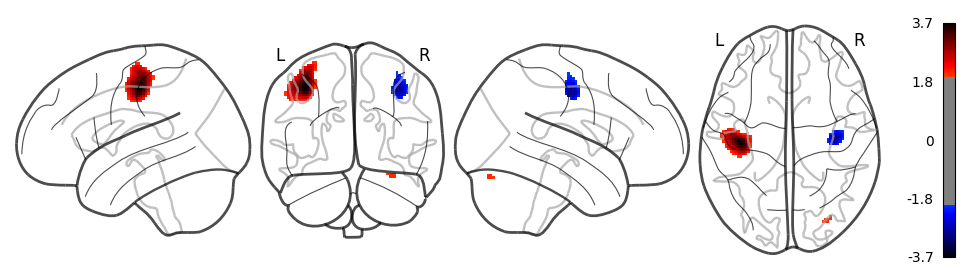

In [ ]:
import nilearn.plotting
nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img('con_0001.nii', 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2)

If we plot the opposite contrast - Left > Right, we observe the inverse of the previous contrast, where the activation values are identical with their signs flipped.

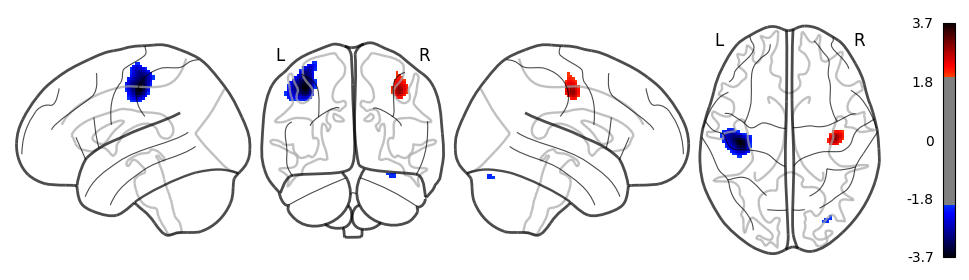

In [ ]:
nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img('con_0002.nii', 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2)